In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [21]:
X = np.load('X.npy')
y = np.load('y.npy')

print(len(X),len(y))

24 24


In [3]:

# Dataset
class KeystrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
class KeystrokeRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, model_type='LSTM'):
        super().__init__()
        if model_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers,
                              batch_first=True, bidirectional=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                               batch_first=True, bidirectional=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers,
                              batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_size * 2, 1)  # Bidirectional

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]      # last timestep
        out = self.fc(out)
        return out               # ❗ NO sigmoid

In [25]:
def train_model(model_type, epochs, lr):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y
    )

    train_ds = KeystrokeDataset(X_train, y_train)
    test_ds  = KeystrokeDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=32)

    model = KeystrokeRNN(model_type=model_type)

    # 🔹 Compute pos_weight = N_neg / N_pos
    pos_weight = torch.tensor(
        len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        dtype=torch.float
    )

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses=[]
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()

            logits = model(batch_x).squeeze()
            loss = criterion(logits, batch_y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

    plt.plot(train_losses)
    plt.title(f"{model_type} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.show()

    # Evaluation
    model.eval()
    probs = []

    with torch.no_grad():
        for batch_x, _ in test_loader:
            logits = model(batch_x).squeeze()
            prob = torch.sigmoid(logits).cpu().numpy()
            probs.extend(prob)
    probs=np.array(probs)

    # Convert probabilities to binary predictions for accuracy calculation
    preds = (probs > 0.5).astype(int)

    fpr, tpr, thresholds = roc_curve(y_test, probs)
    eer_idx = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer = fpr[eer_idx]
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)
    print(f"{model_type} - Test Acc: {acc:.4f}, AUC: {auc:.4f}")

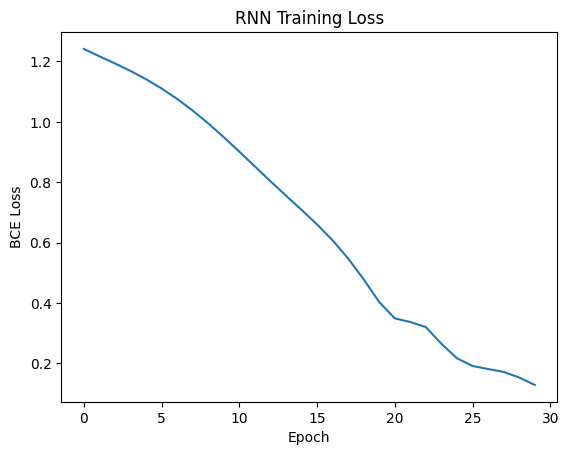

RNN - Test Acc: 0.8000, AUC: 1.0000


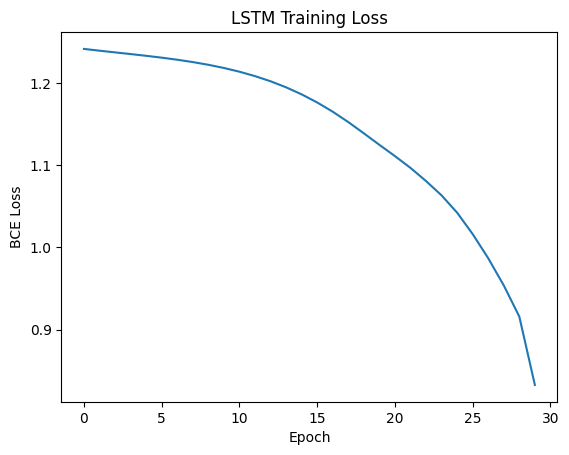

LSTM - Test Acc: 0.8000, AUC: 0.5000


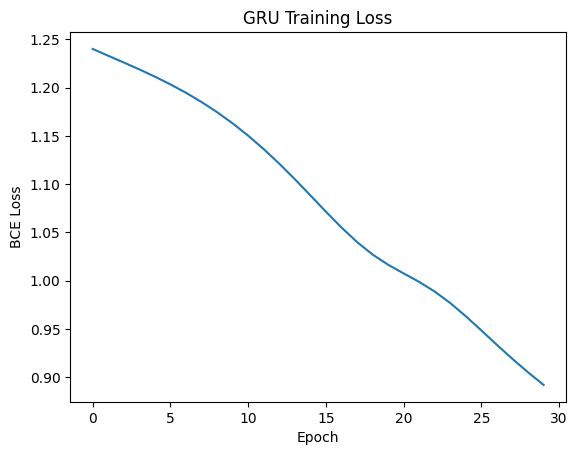

GRU - Test Acc: 0.8000, AUC: 0.5000


In [26]:
for m_type in ['RNN', 'LSTM', 'GRU']:
    train_model(m_type, epochs=30, lr=0.001)

In [29]:
print("Total windows:", len(y))
print("Positive (you, label 1):", np.sum(y == 1), f"({np.mean(y == 1)*100:.1f}%)")
print("Negative (others, label 0):", np.sum(y == 0), f"({np.mean(y == 0)*100:.1f}%)")

# After split
_, _, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print("\nTrain set - pos:", np.sum(y_train == 1), "neg:", np.sum(y_train == 0))
print("Test set  - pos:", np.sum(y_test == 1),  "neg:", np.sum(y_test == 0))

Total windows: 24
Positive (you, label 1): 3 (12.5%)
Negative (others, label 0): 21 (87.5%)

Train set - pos: 2 neg: 17
Test set  - pos: 1 neg: 4


In [30]:
import numpy as np
y = np.load('y.npy')
print("Positive windows per original session (rough estimate):")
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
print("\nAverage windows per session if ~25 original sessions:", len(y)/25)

Positive windows per original session (rough estimate):
{np.int64(0): np.int64(21), np.int64(1): np.int64(3)}

Average windows per session if ~25 original sessions: 0.96
